# Breakdowns of School Buses in NYC 🚌💥

## Initial Data Preparation

In [1]:
# Libraries
library(tidyverse)
library(lubridate)
library(broom)
library(scales)

# Chart Theme
theme_set(theme_bw() +
    theme(
        plot.title = element_text(size = 14, face = "bold"),
        plot.subtitle = element_text(
            size = 10, face = "italic",
            colour = "grey50"
        )
    ))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




In [2]:
df <- read_csv("C:/Users/mathi/OneDrive/Python/Data too Large to Push/bus-breakdowns-delays.csv") %>% 
    janitor::clean_names()

Rows: 545691 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (19): School_Year, Run_Type, Bus_No, Route_Number, Reason, Schools_Servi...
dbl  (2): Busbreakdown_ID, Number_Of_Students_On_The_Bus

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The data is quite large, half a million rows and 21 columns, so a lot to work with!

In [3]:
glimpse(df)

Rows: 545,691
Columns: 21
$ school_year                     <chr> "2015-2016", "2015-2016", "2015-2016",…
$ busbreakdown_id                 <dbl> 1227538, 1227539, 1227540, 1227541, 12…
$ run_type                        <chr> "Special Ed AM Run", "Special Ed AM Ru…
$ bus_no                          <chr> "2621", "1260", "418", "4522", "3124",…
$ route_number                    <chr> "J711", "M351", "3", "M271", "M373", "…
$ reason                          <chr> "Heavy Traffic", "Heavy Traffic", "Hea…
$ schools_serviced                <chr> "75003", "06716", "C445", "02699", "02…
$ occurred_on                     <chr> "11/05/2015 08:10:00 AM", "11/05/2015 …
$ created_on                      <chr> "11/05/2015 08:12:00 AM", "11/05/2015 …
$ boro                            <chr> "New Jersey", "Manhattan", "Bronx", "M…
$ bus_company_name                <chr> "RELIANT TRANS, INC. (B232", "HOYT TRA…
$ how_long_delayed                <chr> NA, "20MNS", "15MIN", "15 MIN", NA, "3…
$ number_of_st

Initial preprocessing:
- parse `school_year`
- parse `how_long_delayed`
- parse date columns
- add helper column for whether delay time contains "min" and filter down to that

In [4]:
data <- df %>%
    mutate(contains_min = str_detect(tolower(how_long_delayed), "min")) %>% 
    filter(contains_min) %>% 
    mutate(
        across(c(school_year, how_long_delayed), ~ parse_number(.x)),
        across(c(occurred_on, created_on, informed_on, last_updated_on), 
                 ~ mdy_hms(.x))
    )



Warning message:
"16 parsing failures.
  row col expected     actual
14421  -- a number MINS      
26035  -- a number minutes   
41352  -- a number est. 25min
46808  -- a number est. 12min
50532  -- a number est. 20min
..... ... ........ ..........
See problems(...) for more details.
"


In [5]:
glimpse(data)

Rows: 473,387
Columns: 22
$ school_year                     <dbl> 2015, 2015, 2015, 2015, 2015, 2015, 20…
$ busbreakdown_id                 <dbl> 1227540, 1227541, 1227543, 1227544, 12…
$ run_type                        <chr> "Pre-K/EI", "Special Ed AM Run", "Spec…
$ bus_no                          <chr> "418", "4522", "HT1502", "142", "56102…
$ route_number                    <chr> "3", "M271", "W796", "W633", "M126", "…
$ reason                          <chr> "Heavy Traffic", "Heavy Traffic", "Hea…
$ schools_serviced                <chr> "C445", "02699", "75407", "75670", "01…
$ occurred_on                     <dttm> 2015-11-05 08:09:00, 2015-11-05 08:12…
$ created_on                      <dttm> 2015-11-05 08:13:00, 2015-11-05 08:14…
$ boro                            <chr> "Bronx", "Manhattan", "Westchester", "…
$ bus_company_name                <chr> "G.V.C., LTD.", "RELIANT TRANS, INC. (…
$ how_long_delayed                <dbl> 15, 15, 30, 20, 30, 30, 30, 15, 10, 15…
$ number_of_st

Good to go!

## Data Wrangling / Visualisation Section

Questions I want to explore visually:
1. Breakdowns by year broken down by borough:
    - 2020 was a good year for breakdowns, though that is not due to the drivers or companies (the mean C word)

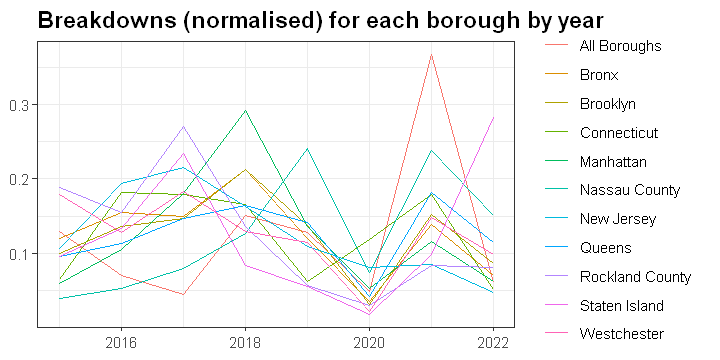

In [28]:
options(repr.plot.width=6, repr.plot.height=3)

data %>%
    drop_na(school_year, boro) %>% 
    count(school_year, boro) %>%
    # Normalise the occurence among boroughs
    group_by(boro) %>% 
    mutate(n = n/sum(n)) %>% 
    ggplot(aes(x = school_year,
               y = n, 
               colour = boro)) +
    geom_line() +
    labs(title = "Breakdowns (normalised) for each borough by year",
         y = NULL, x = NULL, colour = NULL)


2. Breakdowns by year broken down by company:
    - Here, need to filter down the number of companies, let's pick top 10 most frequent ones.
    - Impact of Covid shows the same pattern, otherwise no discernible trend over time

In [8]:
data %>% count(bus_company_name, sort = T) %>% head(10) %>% pull(bus_company_name)

[1] "LEESEL TRANSPORTATION CORP (B2192)"  "PIONEER TRANSPORTATION CORP"        
 [3] "G.V.C., LTD."                        "BORO TRANSIT, INC."                 
 [5] "RELIANT TRANSPORTATION, INC (B2321)" "VAN TRANS LLC (B2192)"              
 [7] "HOYT TRANSPORTATION CORP."           "ALLIED TRANSIT CORP."               
 [9] "PRIDE TRANSPORTATION (SCH AGE)"      "L & M BUS CORP."

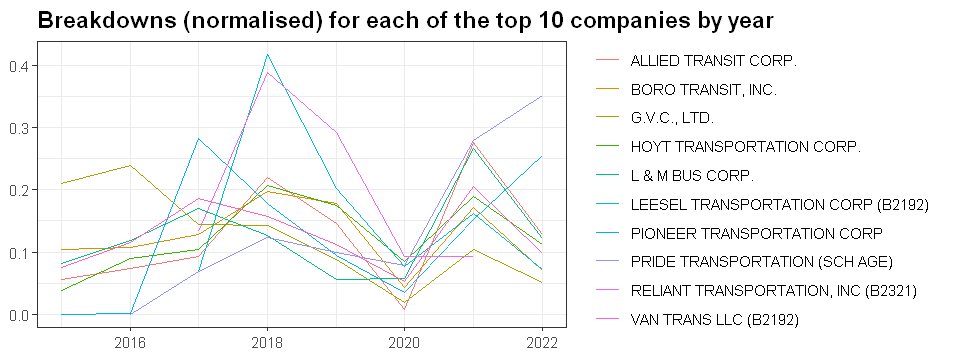

In [9]:
data %>% 
    filter(bus_company_name %in% (data %>% count(bus_company_name, sort = T) %>% head(10) %>% pull(bus_company_name))) %>% 
    count(school_year, bus_company_name) %>% 
    group_by(bus_company_name) %>% 
    mutate(n = n/sum(n)) %>% 
    ggplot(aes(x = school_year,
               y = n, 
               colour = bus_company_name)) +
    geom_line() +
    labs(title = "Breakdowns (normalised) for each of the top 10 companies by year",
         y = NULL, x = NULL, colour = NULL)

3. How long the buses are delayed 
    - over time
    - by company/borough

In [29]:
data %>% 
    group_by(school_year) %>% 
    summarise(mean_delay = mean(how_long_delayed, na.rm = T))

school_year,mean_delay
<dbl>,<dbl>
2015,24.48067
2016,25.53875
2017,24.35765
2018,29.63687
2019,26.66601
2020,27.90419
2021,27.41205
2022,33.24335


Looks like average delays have not changed in recent years. Let's see the development by borough:

`summarise()` has grouped output by 'school_year'. You can override using the
`.groups` argument.


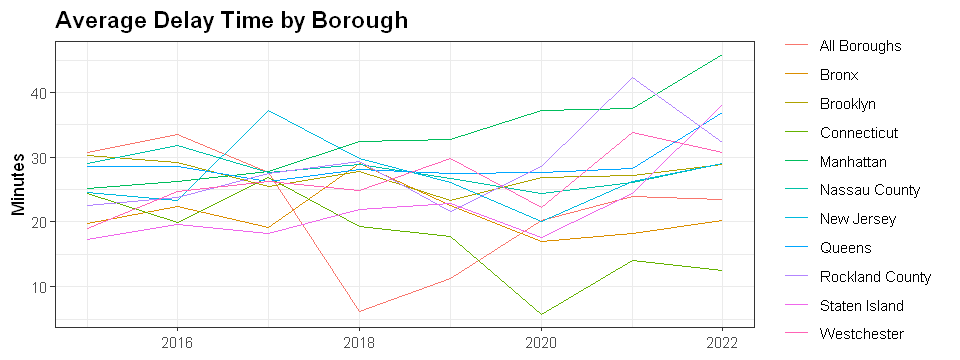

In [12]:
data %>%
    drop_na(boro) %>% 
    group_by(school_year, boro) %>% 
    summarise(mean_delay = mean(how_long_delayed, na.rm = T)) %>% 
    ggplot(aes(x = school_year, y = mean_delay, colour = boro)) +
    geom_line() +
    labs(title = "Average Delay Time by Borough", y = "Minutes", x = NULL, colour = NULL)

It looks like Manhatten has been increasing steadily:

`summarise()` has grouped output by 'school_year'. You can override using the
`.groups` argument.


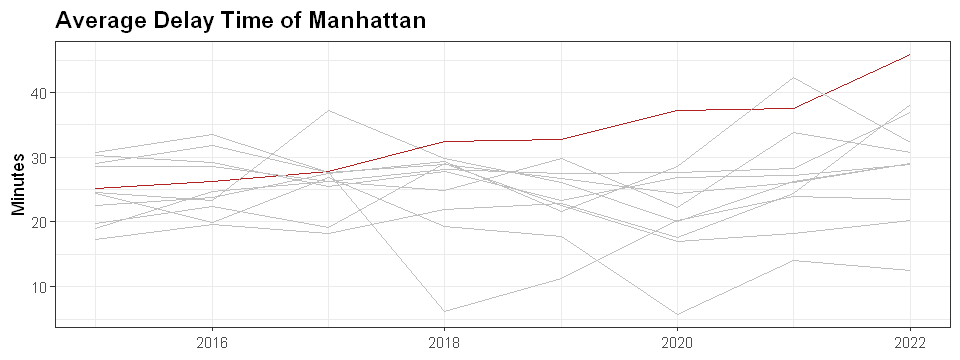

In [13]:
data %>%
    drop_na(boro) %>% 
    group_by(school_year, boro) %>% 
    summarise(mean_delay = mean(how_long_delayed, na.rm = T)) %>% 
    ungroup() %>% 
    mutate(col = ifelse(boro == "Manhattan", "firebrick", "grey75")) %>% 
    ggplot(aes(x = school_year, y = mean_delay, colour = I(col), group = boro)) +
    geom_line() +
    labs(title = "Average Delay Time of Manhattan", y = "Minutes", x = NULL, colour = NULL)

4. How many students are affected
    - by company
    - by borough

`summarise()` has grouped output by 'boro'. You can override using the
`.groups` argument.


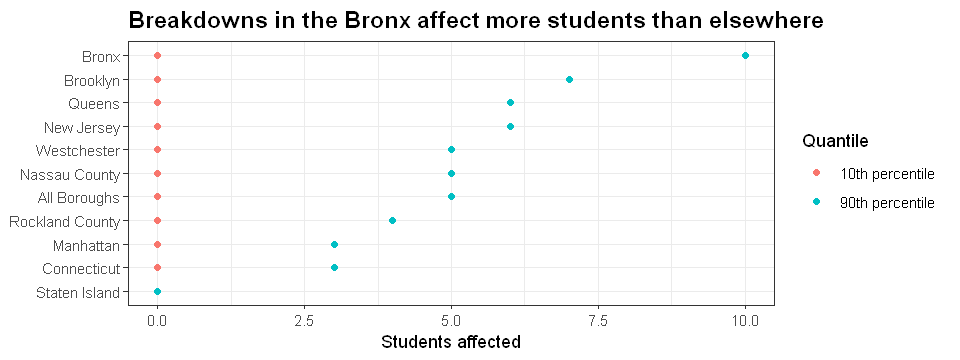

In [14]:
data %>% 
    drop_na(boro) %>% 
    group_by(boro) %>% 
    summarise(value = quantile(number_of_students_on_the_bus, prob=c(0.1, 0.9)),
              quantile = c("10th percentile", "90th percentile")) %>% 
    ggplot(aes(x = value, y = boro %>% reorder(value), colour = quantile)) +
    geom_point() +
    labs(title = "Breakdowns in the Bronx affect more students than elsewhere",
         y = NULL, x = "Students affected", colour = "Quantile")
    

In [36]:
data %>% 
    group_by(boro) %>% 
    summarise(mean_affected = mean(number_of_students_on_the_bus, na.rm = T)) %>% 
    arrange(-mean_affected)

boro,mean_affected
<chr>,<dbl>
New Jersey,5.9640411
Rockland County,5.3813084
Bronx,4.7846758
Queens,3.9113918
NA,3.5941099
Brooklyn,3.5629279
Nassau County,3.3624759
Westchester,2.5821086
All Boroughs,1.8289992


5. Which reasons occur most frequently at which times in
    - the week
    - a day

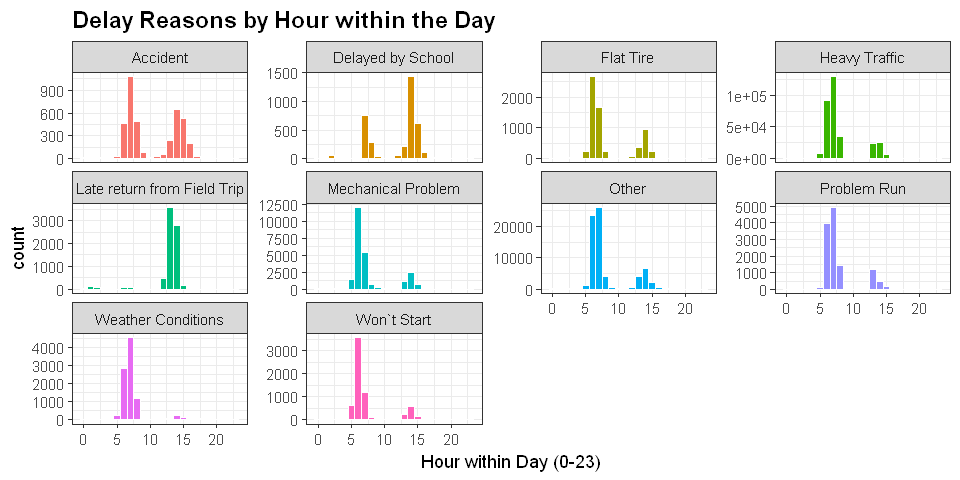

In [39]:
options(repr.plot.width=8, repr.plot.height=4)

data %>% 
  transmute(hour = hour(occurred_on), reason) %>% 
  ggplot(aes(x = hour, fill = reason)) +
  geom_histogram(binwidth = 1, colour = "white") +
  labs(title = "Delay Reasons by Hour within the Day", x = "Hour within Day (0-23)") +
  facet_wrap(~ reason, scales = "free_y") +
  theme(legend.position = "none")

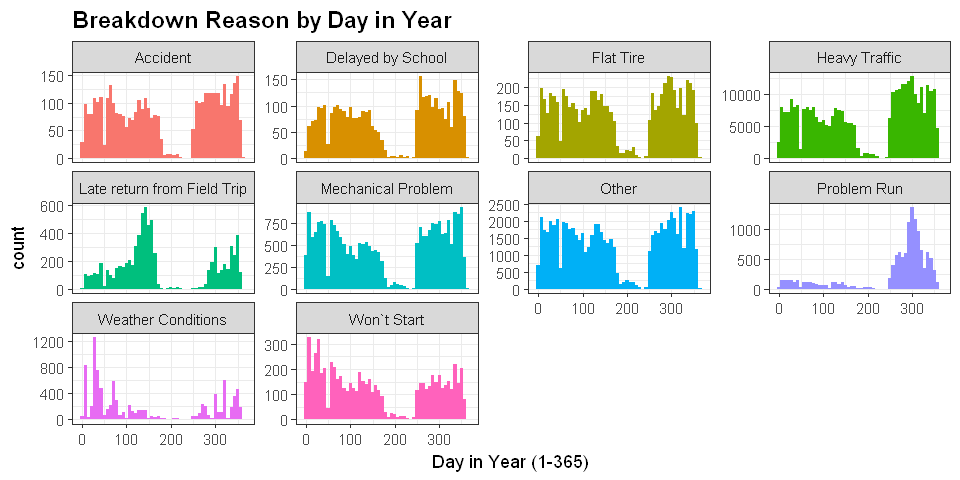

In [40]:
data %>% 
  transmute(doy = yday(occurred_on), reason) %>% 
  ggplot(aes(x = doy, fill = reason)) +
  geom_histogram(bins = 52) +
  facet_wrap(~ reason, scales = "free_y") +
  labs(title = "Breakdown Reason by Day in Year", x = "Day in Year (1-365)") +
  theme(legend.position = "none")

6. Average delay by reason of delay

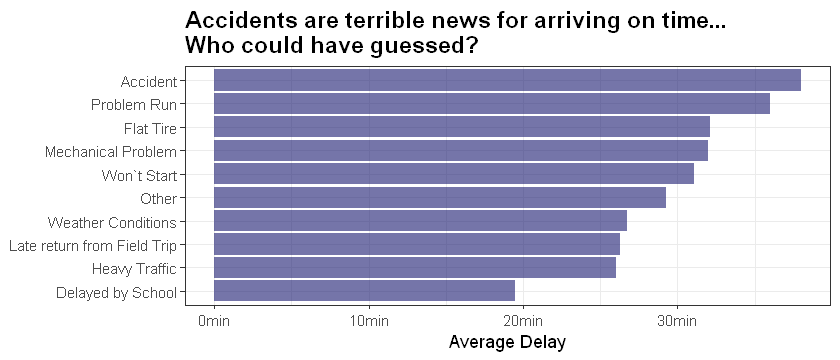

In [26]:
options(repr.plot.width=7, repr.plot.height=3)

data %>% 
  group_by(reason) %>% 
  summarise(mean_delay = mean(how_long_delayed, na.rm = T)) %>% 
  ggplot(aes(mean_delay, 
             reason %>% reorder(mean_delay))) +
  geom_col(fill = "midnightblue", alpha = 0.6) +
  labs(title = "Accidents are terrible news for arriving on time...\nWho could have guessed?",
       y = NULL, x = "Average Delay") +
  scale_x_continuous(labels = number_format(suffix = "min"))